# Rock Classification and Description Using Conventional and Multispectral Drone Imagery
***
### Domenico M. Crisafulli, Misael M. Morales, Charles Neal and Carlos Torres-Verdin
#### The University of Texas at Austin, 2025
***

In [190]:
import os, cv2, glob
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn import metrics as sklmetrics
from skimage import metrics as skimetrics

import keras
import tensorflow as tf
import keras.backend as K
from keras import Model
from keras import layers, losses, metrics, optimizers, activations, callbacks

def check_tf_gpu(verbose:bool=True):
    sys_info = tf.sysconfig.get_build_info()
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    name  = [device.name for device in tf.config.experimental.list_physical_devices('GPU')]
    if verbose:
        print('-'*60)
        print('----------------------- VERSION INFO -----------------------')
        print('TF version: {} | # Device(s) available: {}'.format(version, count))
        print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
        print(tf.config.list_physical_devices()[0],'\n', tf.config.list_physical_devices()[-1])
        print('-'*60+'\n')
    return None
check_tf_gpu()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
TF version: 2.19.0 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.5.1 | cuDNN: 9
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU') 
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
------------------------------------------------------------



In [747]:
def CoreSegNet(in_channels:int=3, out_channels:int=1):
    K.clear_session()
    def convolution_block(inp, num_filters, kernel_size=3, dropout=0.1):
        _ = layers.SeparableConv2D(num_filters, kernel_size=kernel_size, padding="same")(inp)
        _ = layers.GroupNormalization(num_filters)(_)
        _ = activations.gelu(_)
        #_ = layers.SpatialDropout2D(dropout)(_)
        return _

    # Encoder
    input = layers.Input(shape=(None, None, in_channels))
    x = convolution_block(input, 16)
    x = layers.MaxPooling2D(2)(x)
    f1 = x
    x = convolution_block(x, 64)
    x = layers.MaxPooling2D(2)(x)
    f2 = x
    x = convolution_block(x, 256)
    x = layers.MaxPooling2D(2)(x)
    f3 = x
    
    # Decoder
    x = layers.concatenate([x, f3])
    x = convolution_block(x, 256)
    x = layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding='same')(x)

    x = layers.concatenate([x, f2])
    x = convolution_block(x, 64)
    x = layers.Conv2DTranspose(16, kernel_size=2, strides=2, padding='same')(x)

    x = layers.concatenate([x, f1])
    x = convolution_block(x, 16)
    x = layers.Conv2DTranspose(out_channels, kernel_size=2, strides=2, padding='same')(x)

    output = layers.Conv2D(out_channels, kernel_size=1, strides=1, activation='softmax')(x)
    
    return Model(inputs=input, outputs=output)

In [748]:
class CustomLoss(losses.Loss):
    def __init__(self, segmentation_weight=0.90, perceptual_weight=0.05, alpha=0.50, beta=0.50, gamma=0.50):
        super(CustomLoss, self).__init__()
        '''
        alpha: controls the weight of categorical cross-entropy (vs. focal)
        beta:  controls the weight of mse (vs. mae)
        gamma: controls the weight of ssim (vs. psnr)
        '''
        self.a     = segmentation_weight
        self.b     = perceptual_weight if segmentation_weight != 1 else 0
        self.alpha = alpha
        self.beta  = beta
        self.gamma = gamma
        self.focal = losses.CategoricalFocalCrossentropy()

    def call(self, true, pred):
        cce = losses.categorical_crossentropy(true, pred)
        foc = self.focal(true, pred)
        segmentation = self.alpha * cce + (1-self.alpha) * foc

        mse = tf.reduce_mean(tf.square(true - pred))
        mae = tf.reduce_mean(tf.abs(true - pred))
        reconstruction = self.beta * mse + (1-self.beta) * mae

        true_ = (true - keras.ops.min(true)) / (keras.ops.max(true) - keras.ops.min(true))
        pred_ = (pred - keras.ops.min(pred)) / (keras.ops.max(pred) - keras.ops.min(pred))
        ssim = 1 - tf.reduce_mean(tf.image.ssim(true_, pred_, max_val=1.0))
        psnr = 1 / tf.reduce_mean(tf.image.psnr(true_, pred_, max_val=1.0))
        perceptual = self.gamma * ssim + (1-self.gamma) * psnr

        return (self.a * segmentation) + (self.b * perceptual) + ((1-self.a-self.b) * reconstruction)

In [749]:
class MonitorCallback(keras.callbacks.Callback):
    def __init__(self, monitor:int=10):
        super(MonitorCallback, self).__init__()
        self.monitor = monitor
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % self.monitor == 0:
            print('Epoch: {} | Accuracy: {:.3f} | Loss: {:.3e}'.format(epoch+1, logs['accuracy'], logs['loss']))

***
# Multispectral

In [680]:
f_ms_images = os.listdir('data_new/multispectral_camera')
n_ms_images = len(f_ms_images)
print('Number of multispectral camera images:', n_ms_images)

ms_image_names = []
for root, dirs, files in os.walk('data_new/multispectral_camera'):
    for f in files:
        if f.endswith('.png'):
            ms_image_names.append(os.path.join(root, f))
ms_image_names = np.array(ms_image_names).reshape(n_ms_images,4)
print('Images: {}'.format(ms_image_names.shape))

ms_images = []
for i in range(ms_image_names.shape[0]):
    im1 = np.array(Image.open(ms_image_names[i,0]))
    im2 = np.array(Image.open(ms_image_names[i,1]))
    im3 = np.array(Image.open(ms_image_names[i,2]))
    im4 = np.array(Image.open(ms_image_names[i,3]))
    ims = np.dstack((im1,im2,im3,im4))
    #ims_reshaped = resize(ims, (512,512,4), anti_aliasing=True)
    ms_images.append(ims)

Number of multispectral camera images: 19
Images: (19, 4)


In [681]:
data_path = 'data_new/multispectral_camera'
ms_masks = []
folder_list = sorted([f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))], key=lambda x: int(x))
for idx, folder in enumerate(folder_list):
    img_h, img_w, img_c = ms_images[idx].shape
    folder_path = os.path.join(data_path, folder)
    mask_dict = np.zeros((img_h, img_w, 4, 6), dtype=np.uint8)
    for file in sorted(os.listdir(folder_path)):
        if file.endswith('_labeled.npy'):
            parts = file.split('_')  # Extract relevant information
            channel = int(parts[0])  # First number before 'mask'
            label = int(parts[2])  # Second number before 'labeled'
            mask_path = os.path.join(folder_path, file)
            mask_data = np.load(mask_path)
            mm = cv2.resize(mask_data, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
            mask_dict[..., channel-1, label] = mm
    ms_masks.append(mask_dict)

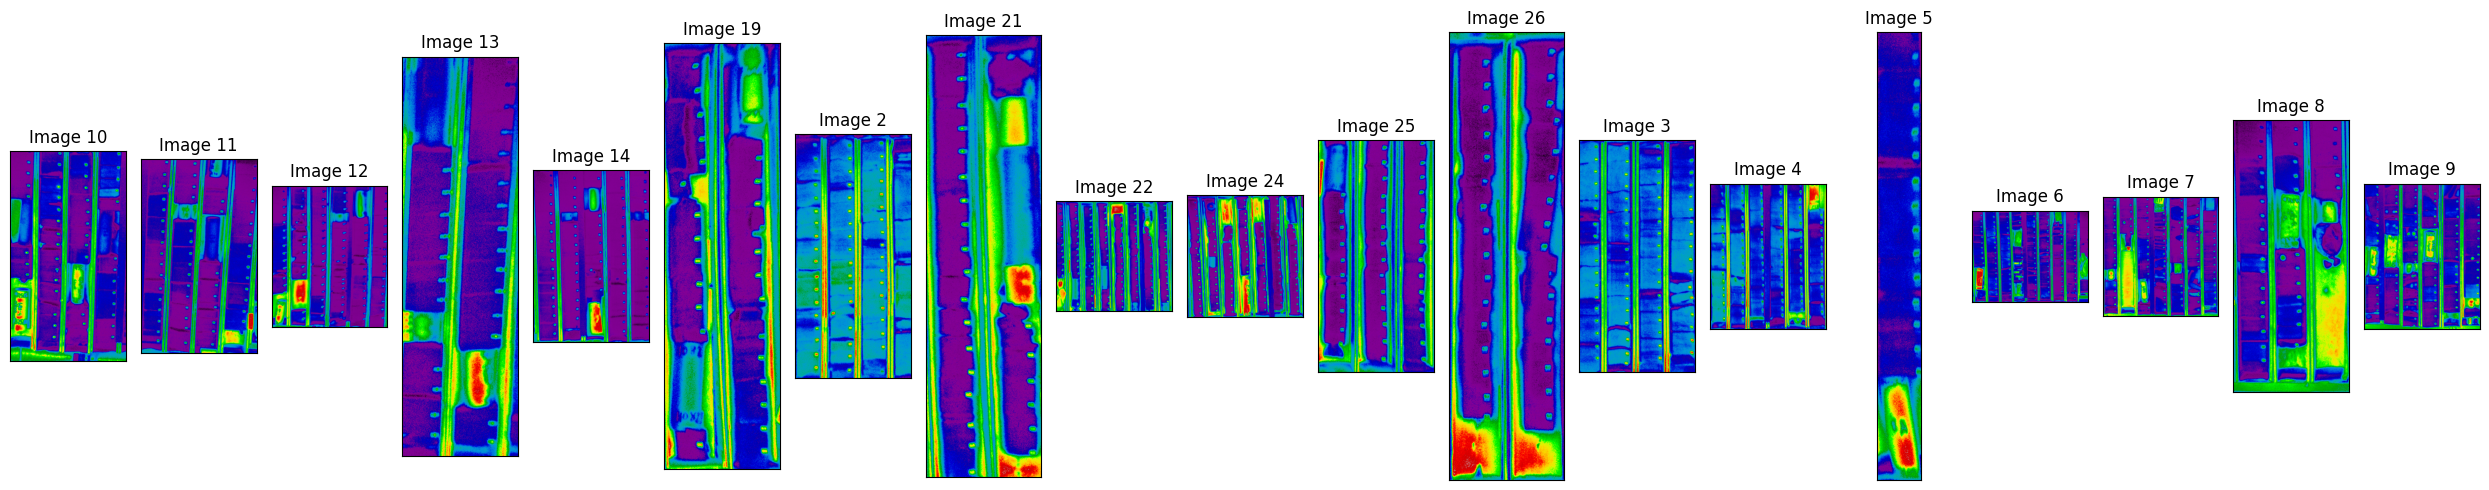

In [682]:
fig, axs = plt.subplots(1, n_ms_images, figsize=(25,5))
for i in range(n_ms_images):
    axs[i].imshow(ms_images[i].mean(-1), cmap='nipy_spectral')
    axs[i].set(xticks=[], yticks=[], title='Image {}'.format(f_ms_images[i]))
plt.tight_layout()
plt.show()

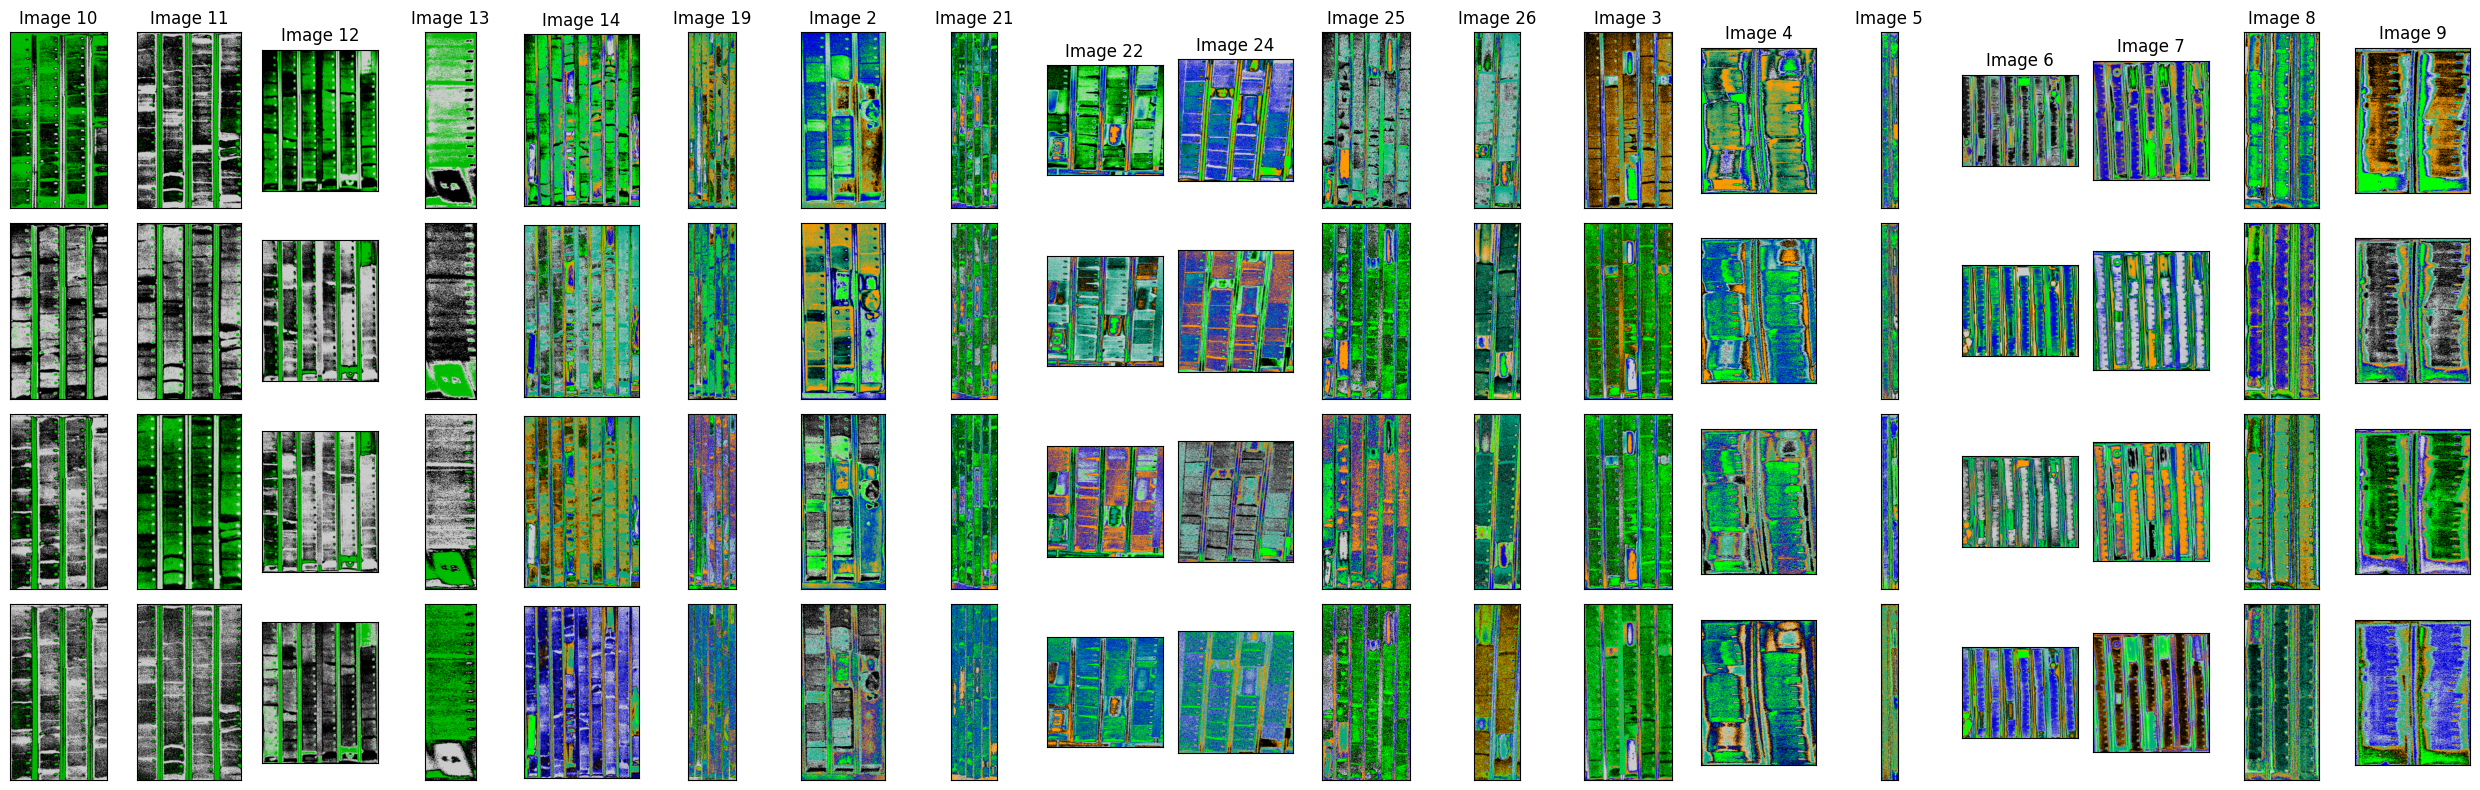

In [683]:
fig, axs = plt.subplots(4, n_ms_images, figsize=(25,8))
for j in range(n_ms_images):
    for i in range(4):
        ax = axs[i, j]
        d = np.argmax(ms_masks[j][...,i,:], axis=-1)
        ax.imshow(d, cmap='nipy_spectral')
        ax.set(xticks=[], yticks=[], title='Image {}'.format(f_ms_images[j]) if i==0 else None)
plt.tight_layout()
plt.show()

In [684]:
patch_size = 256

patched_images = []
for i in range(len(ms_images)):
    im = ms_images[i]
    h, w, c = im.shape
    pad_h = (patch_size - (h % patch_size)) % patch_size
    pad_w = (patch_size - (w % patch_size)) % patch_size
    hh = (pad_h//2, pad_h//2) if (h + 2*(pad_h//2))%patch_size==0 else (pad_h//2 + 1, pad_h//2)
    ww = (pad_w//2, pad_w//2) if (w + 2*(pad_w//2))%patch_size==0 else (pad_w//2 + 1, pad_w//2)
    im_pad = np.pad(im, (hh, ww, (0, 0)), mode='constant', constant_values=0)
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = im_pad[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    patched_images.append(np.array(patches))

patched_masks = []
for i in range(len(ms_masks)):
    mask = ms_masks[i]
    h, w, c, l = mask.shape
    pad_h = (patch_size - (h % patch_size)) % patch_size
    pad_w = (patch_size - (w % patch_size)) % patch_size
    hh = (pad_h//2, pad_h//2) if (h + 2*(pad_h//2))%patch_size==0 else (pad_h//2 + 1, pad_h//2)
    ww = (pad_w//2, pad_w//2) if (w + 2*(pad_w//2))%patch_size==0 else (pad_w//2 + 1, pad_w//2)
    mask_pad = np.pad(mask, (hh, ww, (0, 0), (0, 0)), mode='constant', constant_values=0)
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = mask_pad[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    patched_masks.append(np.array(patches))

In [765]:
x_patched = np.concatenate(patched_images, axis=0)/255.0

y_patched = np.concatenate(patched_masks, axis=0)
y_patched = np.where(y_patched==10, 4, y_patched)
y_patched = np.where(y_patched==13, 5, y_patched).max(-2)/5

print(f"X shape: {x_patched.shape}, Y shape: {y_patched.shape}")
print('Unique labels: {}'.format(np.unique(y_patched)))

X shape: (214, 256, 256, 4), Y shape: (214, 256, 256, 6)
Unique labels: [0.  0.2 0.4 0.6 0.8 1. ]


In [766]:
X_train, X_test, y_train, y_test = train_test_split(x_patched, y_patched, test_size=0.1, random_state=42)
ntrain, ntest = X_train.shape[0], X_test.shape[0]
print('X_train: {}  | X_test: {}'.format(X_train.shape, X_test.shape))
print('y_train: {} | y_test: {}'.format(y_train.shape, y_test.shape))

X_train: (192, 256, 256, 4)  | X_test: (22, 256, 256, 4)
y_train: (192, 256, 256, 6) | y_test: (22, 256, 256, 6)


In [ ]:
############## Train Model ################
model = CoreSegNet(in_channels=4, out_channels=6)
print('# parameters: {:,}'.format(model.count_params())+'\n'+'-'*30)

#optimizer = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-6)
optimizer = optimizers.Adam(learning_rate=1e-3)
criterion = losses.CategoricalFocalCrossentropy()
#criterion = CustomLoss()
metricIOU = metrics.OneHotMeanIoU(num_classes=10)
model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy',metricIOU])

esCallback = callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
mcCallback = callbacks.ModelCheckpoint('CoreSegNet.keras', monitor='val_accuracy', save_best_only=True)
CustomCBs  = [MonitorCallback(monitor=10), esCallback, mcCallback]

start = time()
fit = model.fit(X_train, y_train,
                batch_size       = 16,
                epochs           = 201,
                validation_split = 0.2,
                shuffle          = True,
                verbose          = 0,)
                #callbacks        = [CustomCBs])
print('-'*30+'\n'+'Training time: {:.2f} minutes'.format((time()-start)/60))
model.save('CoreSegNet2_ms.keras')
fit = pd.DataFrame(fit.history)
fit.to_csv('CoreSegNet2_ms_history.csv', index=False)

# parameters: 236,212
------------------------------


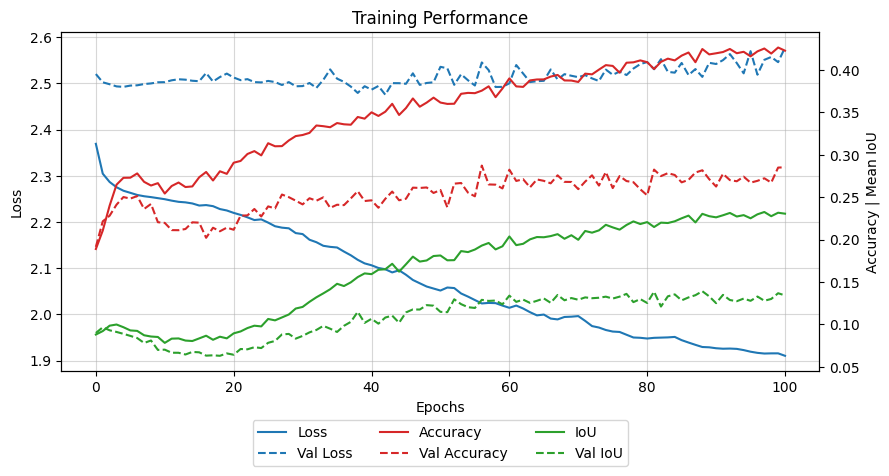

In [753]:
hues = ['tab:blue','tab:red','tab:green', 'tab:red','tab:blue','k','tab:green']

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
axb = ax.twinx()

axb.plot(fit.iloc[:,0], color=hues[1], label='Accuracy')
axb.plot(fit.iloc[:,3], color=hues[1], linestyle='--', label='Val Accuracy')

ax.plot(fit.iloc[:,1], color=hues[0], label='Loss')
ax.plot(fit.iloc[:,4], color=hues[0], linestyle='--', label='Val Loss')

axb.plot(fit.iloc[:,2], color=hues[2], label='IoU')
axb.plot(fit.iloc[:,5], color=hues[2], linestyle='--', label='Val IoU')

ax.set(xlabel='Epochs', ylabel='Loss', title='Training Performance')
axb.set(ylabel='Accuracy | Mean IoU')
ax.grid(True, which='both', alpha=0.5)

lines_ax, labels_ax = ax.get_legend_handles_labels()
lines_axb, labels_axb = axb.get_legend_handles_labels()
ax.legend(lines_ax + lines_axb, labels_ax + labels_axb, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.3))

plt.tight_layout()
plt.show()

In [754]:
y_train_pred = model.predict(X_train[:100], verbose=0)
y_test_pred  = model.predict(X_test[:100], verbose=0)
print('Pred - train: {} | test: {}'.format(y_train_pred.shape, y_test_pred.shape))

2025-07-04 15:33:59.418323: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng20{k2=2,k4=0,k5=0,k6=0,k7=0,k19=0} for conv %cudnn-conv-bias-activation.24 = (f32[22,256,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,512,32,32]{3,2,1,0} %bitcast.3361, f32[256,512,1,1]{3,2,1,0} %bitcast.3368, f32[256]{0} %bitcast.3370), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/separable_conv2d_3_1/separable_conv2d" source_file="/home/mmorales/miniconda3/envs/flow/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-07-04 15:33:59.419618: E external/local_xla/xla/service/slow_operation_alarm.cc

Pred - train: (100, 256, 256, 6) | test: (22, 256, 256, 6)


In [755]:
encoder = Model(inputs=model.input, outputs=model.get_layer('max_pooling2d_2').output)
z_train = encoder.predict(X_train[:100], verbose=0)
z_test  = encoder.predict(X_test[:100], verbose=0)
print('Encoded - train: {} | test: {}'.format(z_train.shape, z_test.shape))

Encoded - train: (100, 32, 32, 256) | test: (22, 32, 32, 256)


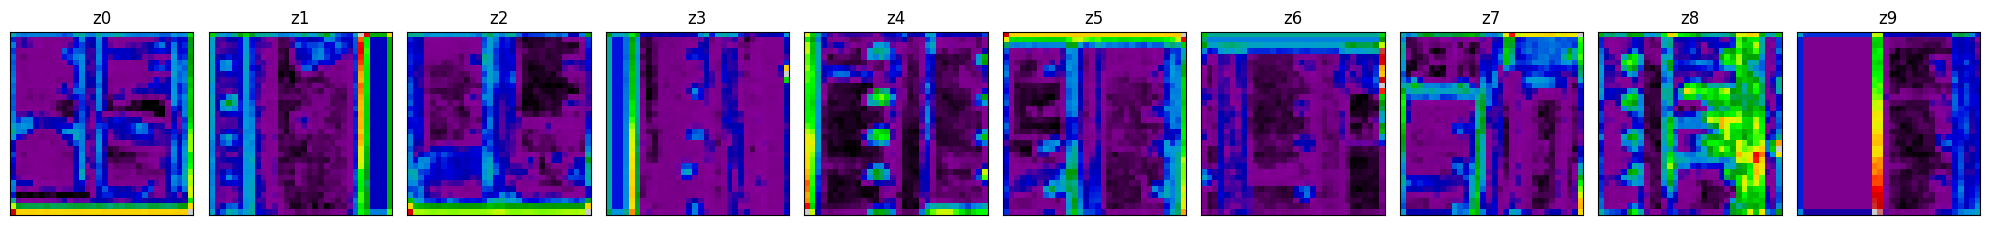

In [756]:
fig, axs = plt.subplots(1, 10, figsize=(20,4), sharex=True, sharey=True)
for j in range(10):
    ax = axs[j]
    ax.imshow(z_train[j].mean(-1), cmap='nipy_spectral')
    ax.set(xticks=[], yticks=[], title='z{}'.format(j))
plt.tight_layout()
plt.show()

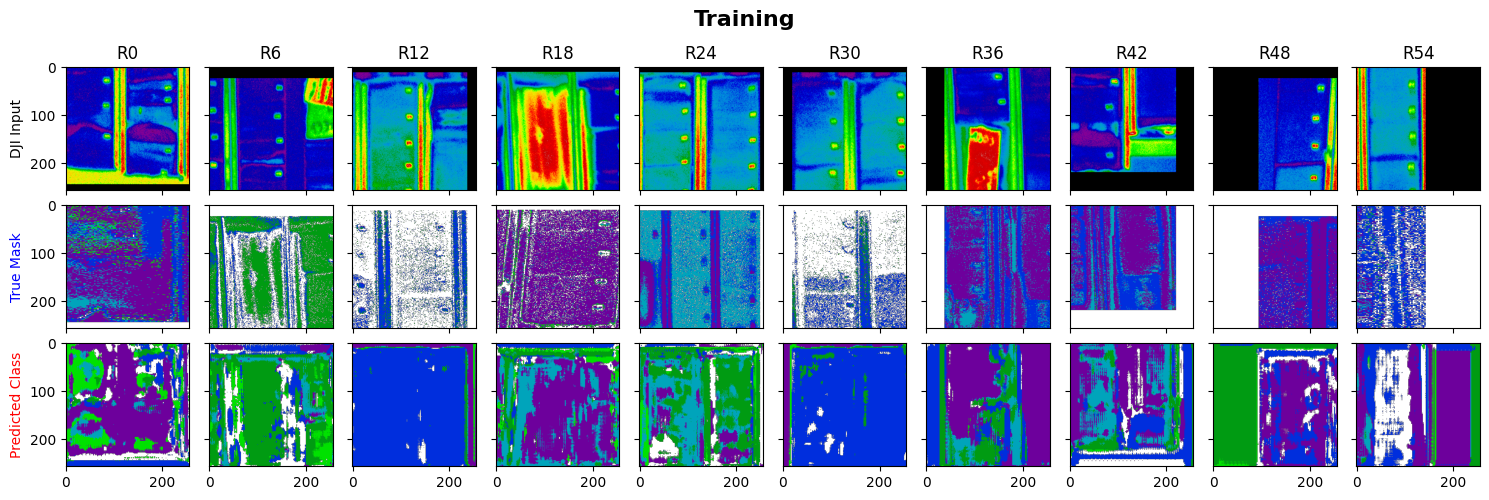

In [763]:
labels = ['DJI Input', 'True Mask', 'Predicted Class']
colors = ['black','blue','red']

fig, axs = plt.subplots(3, 10, figsize=(15,5), sharex=True, sharey=True)
mult = 6
for j in range(10):
    k = j*mult
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    ax1.imshow(X_train[k].mean(-1), cmap='nipy_spectral')
    ax1.set(title='R{}'.format(k))

    true = y_train[k].argmax(-1)
    pred = y_train_pred[k].argmax(-1)

    dt = np.ma.masked_where(true==0, true)
    dp = np.ma.masked_where(pred==0, pred)

    ax2.imshow(dt, vmin=0, vmax=9, cmap='nipy_spectral')
    ax3.imshow(dp, vmin=0, vmax=9, cmap='nipy_spectral')

    [a.set_ylabel(labels[i], color=colors[i]) for i,a in enumerate([ax1,ax2,ax3])] if j==0 else None

fig.suptitle('Training', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

In [764]:
train_mse = sklmetrics.mean_squared_error(y_train[:100].reshape(100,-1), y_train_pred[:100].reshape(100,-1))
test_mse  = sklmetrics.mean_squared_error(y_test.reshape(ntest,-1), y_test_pred.reshape(ntest,-1))
print('MSE      - Train: {:.3f} | Test: {:.3f}'.format(train_mse, test_mse))

ssim_train = skimetrics.structural_similarity(y_train[:100], y_train_pred[:100], multichannel=True, channel_axis=-1, data_range=1.0)
ssim_test  = skimetrics.structural_similarity(y_test, y_test_pred, multichannel=True, channel_axis=-1, data_range=1.0)
print('SSIM     - Train: {:.3f} | Test: {:.3f}'.format(ssim_train, ssim_test))

acc_train = sklmetrics.accuracy_score(y_train[:100].argmax(-1).flatten(), y_train_pred[:100].argmax(-1).flatten())
acc_test  = sklmetrics.accuracy_score(y_test.argmax(-1).flatten(), y_test_pred.argmax(-1).flatten())
print('Accuracy - Train: {:.3f} | Test: {:.3f}'.format(acc_train, acc_test))

MSE      - Train: 3.952 | Test: 4.562
SSIM     - Train: 0.011 | Test: 0.002
Accuracy - Train: 0.449 | Test: 0.277


***
## Conventional camera

In [159]:
patch_size = 384

In [160]:
fnames = []
for root, dirs, files in os.walk('data_new/conventional_camera'):
    for f in files:
        if f.endswith('.png'):
            fnames.append(os.path.join(root, f))

cc_images = []
for i in range(len(fnames)):
    img = np.array(Image.open(fnames[i]))
    cc_images.append(img)
    print(img.shape)

(2400, 1340, 3)
(2600, 1480, 3)
(2650, 2200, 3)
(2850, 730, 3)
(2750, 1975, 3)
(2400, 550, 3)
(2350, 600, 3)
(2450, 2425, 3)
(2450, 2200, 3)
(1750, 800, 3)
(2350, 570, 3)
(2500, 1182, 3)
(2425, 1200, 3)
(2400, 1975, 3)
(2600, 250, 3)
(2500, 3160, 3)
(2520, 2400, 3)
(2500, 1050, 3)
(2450, 2050, 3)


In [161]:
def load_image(fname):
    try:
        img = Image.open(fname).convert("RGB")  # Convert grayscale to RGB
        return np.array(img)
    except Exception as e:
        print(f"Error loading {fname}: {e}")
        return None

In [162]:
def pad_image(image, patch_size=384):
    if len(image.shape) == 3:
        h, w, c = image.shape       
        pad_h = (patch_size - (h % patch_size)) % patch_size
        pad_w = (patch_size - (w % patch_size)) % patch_size
        padded_image = np.pad(image, ((pad_h//2, pad_h//2), (pad_w//2, pad_w//2), (0, 0)), mode='constant', constant_values=0)
    else:
        h, w = image.shape
        pad_h = (patch_size - (h % patch_size)) % patch_size
        pad_w = (patch_size - (w % patch_size)) % patch_size
        padded_image = np.pad(image, ((pad_h//2, pad_h//2), (pad_w//2, pad_w//2)), mode='constant', constant_values=0)
    return padded_image

In [163]:
def crop_into_patches(image, patch_size=384):
    if len(image.shape) == 3:
        h, w, c = image.shape
        patches = []
        for i in range(0, h, patch_size):
            for j in range(0, w, patch_size):
                patch = image[i:i+patch_size, j:j+patch_size, :]
                if patch.shape == (patch_size, patch_size, 3):
                    patches.append(patch)
        return np.array(patches) if patches else None
    else:
        h, w = image.shape
        patches = []
        for i in range(0, h, patch_size):
            for j in range(0, w, patch_size):
                patch = image[i:i+patch_size, j:j+patch_size]
                if patch.shape == (patch_size, patch_size):
                    patches.append(patch)
        return np.array(patches) if patches else None

In [164]:
base_path = "data_new/conventional_camera"
cc_images_patches = []
fnames = []
for root, _, files in os.walk(base_path):
    for f in files:
        if f.lower().endswith(".png"):
            full_path = os.path.join(root, f)
            fnames.append(full_path)
if not fnames:
    print("ERROR: No PNG images were found. Check directory paths!")
else:
    print(f"Found {len(fnames)} PNG images.")

for fname in tqdm(fnames, desc='Processing images'):
    img = load_image(fname)
    if img is None:
        continue

    padded_img = pad_image(img, patch_size=patch_size)
    patches = crop_into_patches(padded_img, patch_size=patch_size)

    if patches is not None:
        cc_images_patches.append(patches)
    else:
        print(f"WARNING: No valid patches extracted from {fname}")

print("Final shape per subject:")
for i, patches in enumerate(cc_images_patches):
    print(f"Subject {i+1}: {patches.shape}")

Found 19 PNG images.


Processing images: 100%|██████████| 19/19 [00:03<00:00,  6.28it/s]

Final shape per subject:
Subject 1: (28, 384, 384, 3)
Subject 2: (28, 384, 384, 3)
Subject 3: (42, 384, 384, 3)
Subject 4: (16, 384, 384, 3)
Subject 5: (40, 384, 384, 3)
Subject 6: (14, 384, 384, 3)
Subject 7: (14, 384, 384, 3)
Subject 8: (42, 384, 384, 3)
Subject 9: (42, 384, 384, 3)
Subject 10: (15, 384, 384, 3)
Subject 11: (14, 384, 384, 3)
Subject 12: (28, 384, 384, 3)
Subject 13: (24, 384, 384, 3)
Subject 14: (35, 384, 384, 3)
Subject 15: (7, 384, 384, 3)
Subject 16: (63, 384, 384, 3)
Subject 17: (49, 384, 384, 3)
Subject 18: (21, 384, 384, 3)
Subject 19: (42, 384, 384, 3)


In [165]:
folder = "data_new/conventional_camera"
image_files = [f for f in os.listdir(folder) if f.endswith("Drone_Cropped.png")]
image_indices = [int(f.split("Drone_Cropped.png")[0]) for f in image_files]

masks, mask_data = {}, {}
for img_idx in image_indices:
    mask_files = [f for f in os.listdir(folder) if f.startswith('{}mask'.format(img_idx))]
    class_labels = [int(f.split("_")[1]) for f in mask_files]
    for c in class_labels:
        dd = np.load(os.path.join(folder, '{}mask_{}_modified.npy'.format(img_idx, c)))
        if img_idx not in masks:
            masks[img_idx] = {}
        masks[img_idx][c] = dd

for img_idx in image_indices:
    for i in range(10):
        if i not in masks[img_idx]:
            existing_classes = list(masks[img_idx].keys())
            H, W = masks[img_idx][existing_classes[0]].shape
            masks[img_idx][i] = np.zeros((H,W), dtype=np.uint8)
    mask_data[img_idx] = np.stack([masks[img_idx][i] for i in range(10)], axis=-1)

In [166]:
mask_patches = {}
for img_idx in image_indices:
    dd = mask_data[img_idx]
    dd_padded = pad_image(dd, patch_size=patch_size)
    p = []
    for i in range(10):
        p.append(crop_into_patches(dd_padded[...,i], patch_size=patch_size))
    mask_patches[img_idx] = np.stack(p, axis=-1)
        
for i, patches in enumerate(mask_patches):
    print(f"Subject {image_indices[i]}: {mask_patches[image_indices[i]].shape}")

Subject 10: (28, 384, 384, 10)
Subject 11: (28, 384, 384, 10)
Subject 12: (42, 384, 384, 10)
Subject 13: (16, 384, 384, 10)
Subject 14: (40, 384, 384, 10)
Subject 19: (14, 384, 384, 10)
Subject 21: (14, 384, 384, 10)
Subject 22: (42, 384, 384, 10)
Subject 24: (42, 384, 384, 10)
Subject 25: (15, 384, 384, 10)
Subject 26: (14, 384, 384, 10)
Subject 2: (28, 384, 384, 10)
Subject 3: (24, 384, 384, 10)
Subject 4: (35, 384, 384, 10)
Subject 5: (7, 384, 384, 10)
Subject 6: (63, 384, 384, 10)
Subject 7: (49, 384, 384, 10)
Subject 8: (21, 384, 384, 10)
Subject 9: (42, 384, 384, 10)


In [167]:
x_patched = np.concatenate(cc_images_patches, axis=0)/255.0
y_patched = np.concatenate(list(mask_patches.values()), axis=0)/255.0
print(f"X shape: {x_patched.shape}, Y shape: {y_patched.shape}")

labelmap = np.argmax(y_patched, axis=-1)

X shape: (564, 384, 384, 3), Y shape: (564, 384, 384, 10)


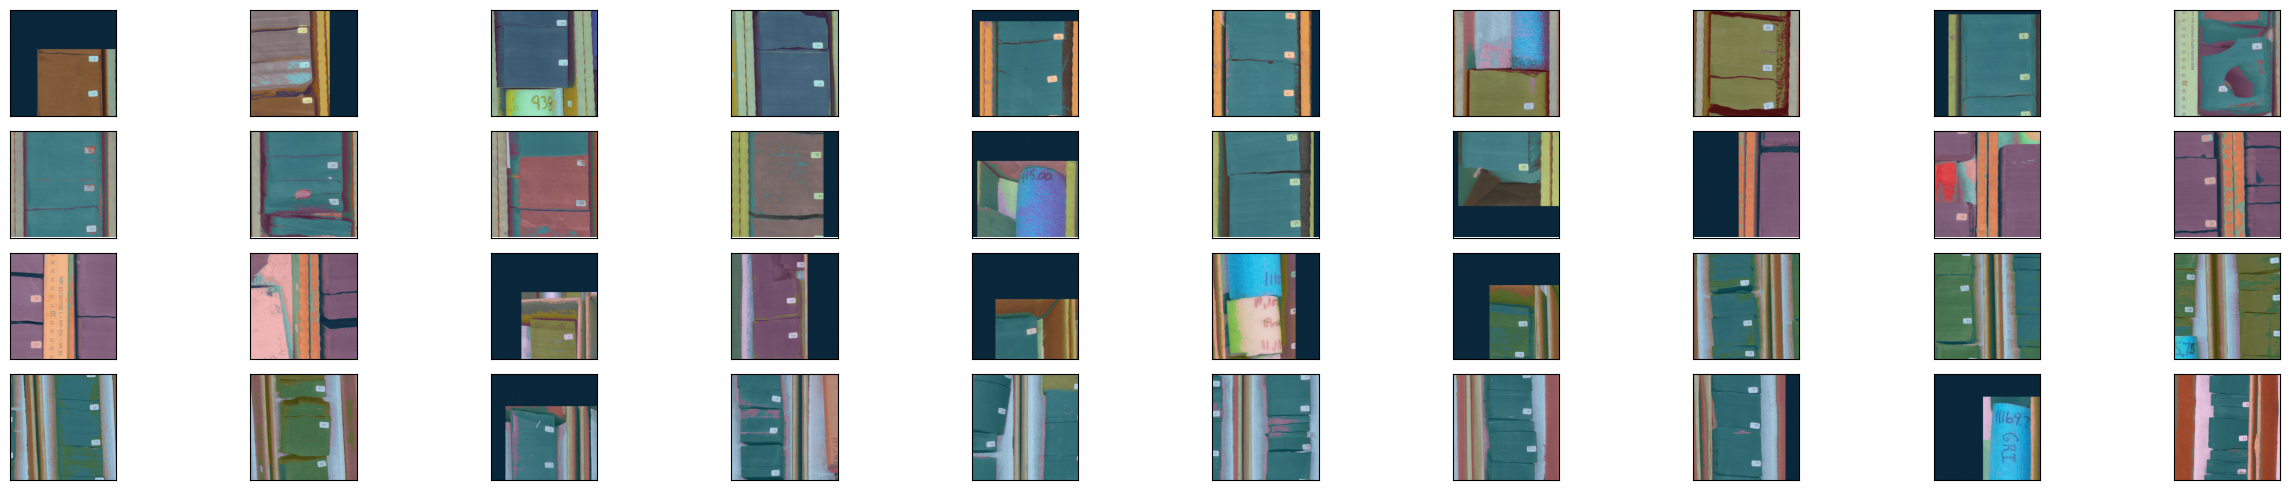

In [168]:
k, mult = 0, 7
fig, axs = plt.subplots(4, 10, figsize=(25,5))
for i in range(4):
    for j in range(10):
        ax = axs[i,j]
        ax.imshow(x_patched[k*mult])
        ax.imshow(labelmap[k*mult], alpha=0.33, cmap='tab10')
        ax.set(xticks=[], yticks=[])
        k += 1
plt.tight_layout()
plt.show()

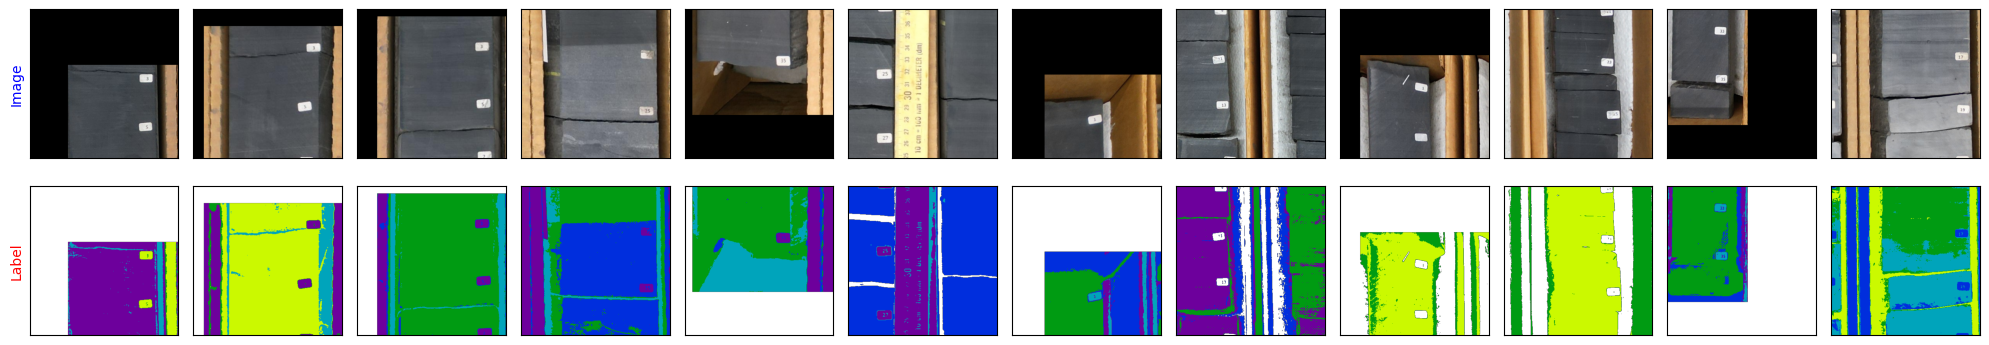

In [169]:
mult = 28
fig, axs = plt.subplots(2, 12, figsize=(20,4), sharex=True, sharey=True)
for j in range(12):
    ax1, ax2 = axs[0,j], axs[1,j]
    k = j*mult

    p = y_patched[k].argmax(-1)
    mp = np.ma.masked_where(p == 0, p)

    ax1.imshow(x_patched[k])
    ax2.imshow(mp, cmap='nipy_spectral', vmin=0, vmax=9)
    [a.set(xticks=[], yticks=[]) for a in [ax1, ax2]]
    [a.set_ylabel(['Image','Label'][i], color=['b','r'][i]) for i, a in enumerate([ax1, ax2])] if j==0 else None
plt.tight_layout()
plt.show()

***
## CoreSegNet

In [185]:
X_train, X_test, y_train, y_test = train_test_split(x_patched, y_patched, test_size=0.1, random_state=42)
ntrain, ntest = X_train.shape[0], X_test.shape[0]
print('X_train: {}  | X_test: {}'.format(X_train.shape, X_test.shape))
print('y_train: {} | y_test: {}'.format(y_train.shape, y_test.shape))

X_train: (507, 384, 384, 3)  | X_test: (57, 384, 384, 3)
y_train: (507, 384, 384, 10) | y_test: (57, 384, 384, 10)


In [ ]:
############## Train Model ################
model = CoreSegNet(in_channels=3, out_channels=10)
print('# parameters: {:,}'.format(model.count_params())+'\n'+'-'*30)

#optimizer = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-6)
optimizer = optimizers.Adam(learning_rate=1e-3)
criterion = losses.CategoricalFocalCrossentropy()
#criterion = CustomLoss()
metricIOU = metrics.OneHotMeanIoU(num_classes=10)
model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy',metricIOU])

esCallback = callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
mcCallback = callbacks.ModelCheckpoint('CoreSegNet.keras', monitor='val_accuracy', save_best_only=True)
CustomCBs  = [MonitorCallback(monitor=10), esCallback, mcCallback]

start = time()
fit = model.fit(X_train, y_train,
                batch_size       = 16,
                epochs           = 101,
                validation_split = 0.2,
                shuffle          = True,
                verbose          = 0,)
                #callbacks        = [CustomCBs])
print('-'*30+'\n'+'Training time: {:.2f} minutes'.format((time()-start)/60))
model.save('CoreSegNet2_cc.keras')
fit = pd.DataFrame(fit.history)
fit.to_csv('CoreSegNet2_cc_history.csv', index=False)

# parameters: 236,515
------------------------------
------------------------------
Training time: 4.18 minutes


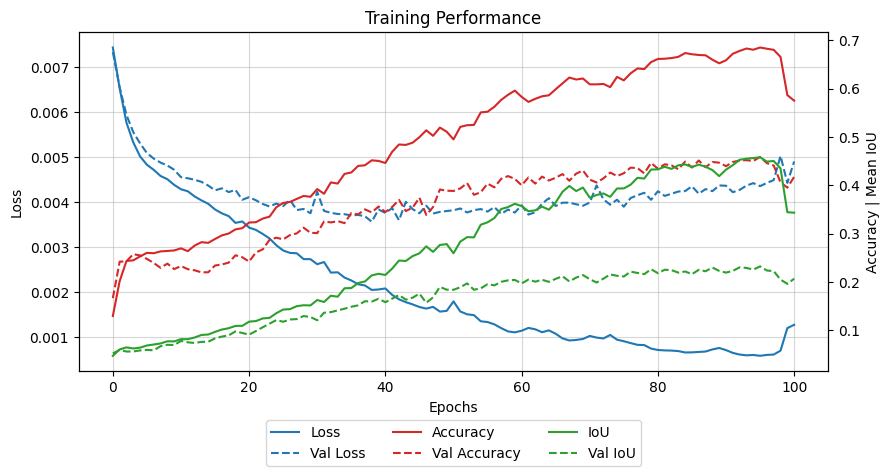

In [196]:
hues = ['tab:blue','tab:red','tab:green', 'tab:red','tab:blue','k','tab:green']

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
axb = ax.twinx()

axb.plot(fit.iloc[:,0], color=hues[1], label='Accuracy')
axb.plot(fit.iloc[:,3], color=hues[1], linestyle='--', label='Val Accuracy')

ax.plot(fit.iloc[:,1], color=hues[0], label='Loss')
ax.plot(fit.iloc[:,4], color=hues[0], linestyle='--', label='Val Loss')

axb.plot(fit.iloc[:,2], color=hues[2], label='IoU')
axb.plot(fit.iloc[:,5], color=hues[2], linestyle='--', label='Val IoU')

ax.set(xlabel='Epochs', ylabel='Loss', title='Training Performance')
axb.set(ylabel='Accuracy | Mean IoU')
ax.grid(True, which='both', alpha=0.5)

lines_ax, labels_ax = ax.get_legend_handles_labels()
lines_axb, labels_axb = axb.get_legend_handles_labels()
ax.legend(lines_ax + lines_axb, labels_ax + labels_axb, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.3))

plt.tight_layout()
plt.show()

In [197]:
y_train_pred = model.predict(X_train[:100], verbose=0)
y_test_pred  = model.predict(X_test[:100], verbose=0)
print('Pred - train: {} | test: {}'.format(y_train_pred.shape, y_test_pred.shape))

Pred - train: (100, 384, 384, 10) | test: (57, 384, 384, 10)


In [227]:
encoder = Model(inputs=model.input, outputs=model.get_layer('max_pooling2d_2').output)
z_train = encoder.predict(X_train[:100], verbose=0)
z_test  = encoder.predict(X_test[:100], verbose=0)
print('Encoded - train: {} | test: {}'.format(z_train.shape, z_test.shape))

Encoded - train: (100, 48, 48, 256) | test: (57, 48, 48, 256)


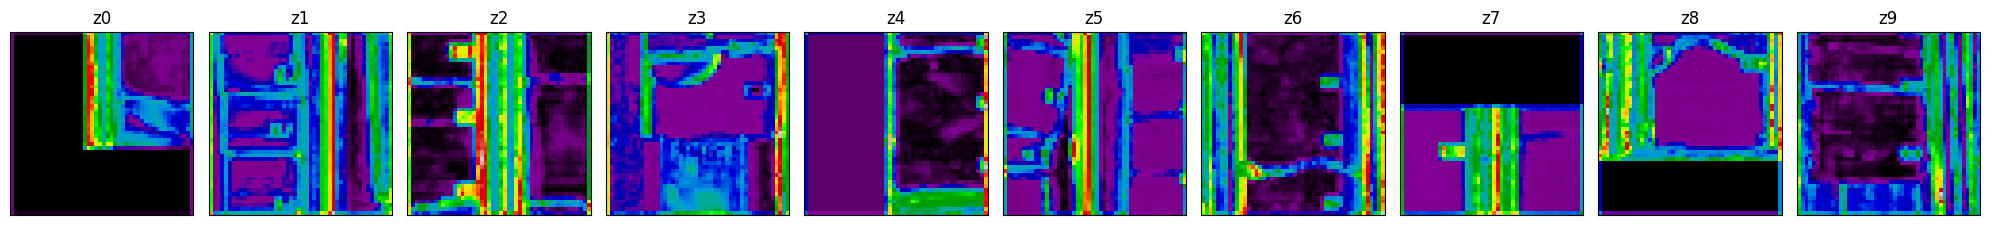

In [240]:
fig, axs = plt.subplots(1, 10, figsize=(20,4), sharex=True, sharey=True)
for j in range(10):
    ax = axs[j]
    ax.imshow(z_train[j].mean(-1), cmap='nipy_spectral')
    ax.set(xticks=[], yticks=[], title='z{}'.format(j))
plt.tight_layout()
plt.show()

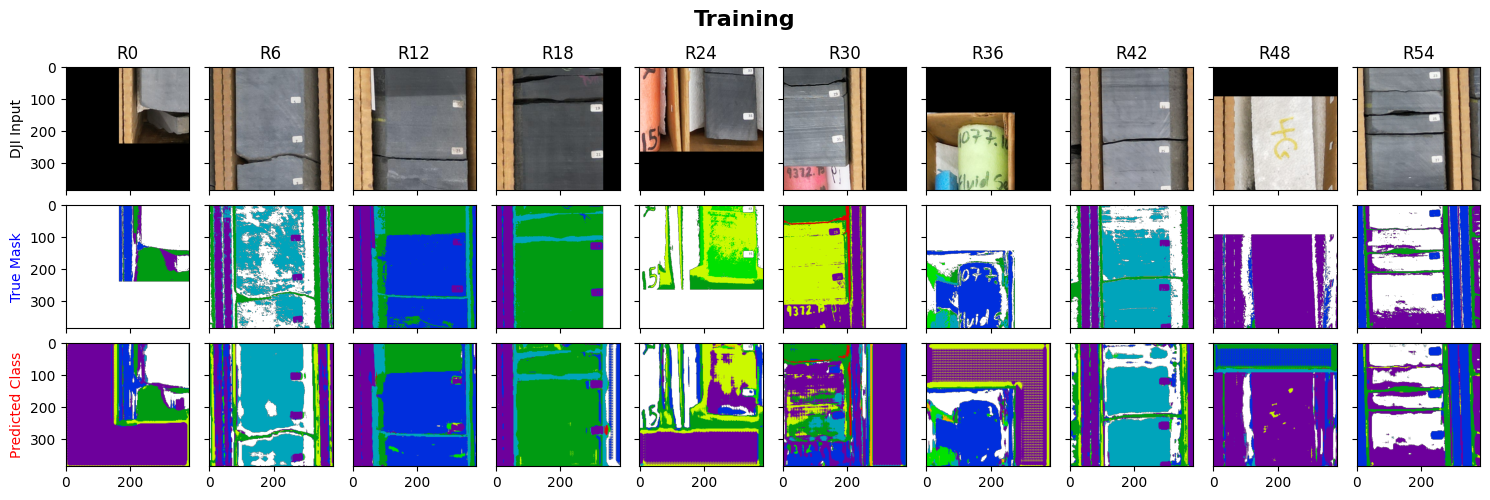

In [245]:
labels = ['DJI Input', 'True Mask', 'Predicted Class']
colors = ['black','blue','red']
fig, axs = plt.subplots(3, 10, figsize=(15,5), sharex=True, sharey=True)

mult = 6

for j in range(10):
    k = j*mult
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    ax1.imshow(X_train[k])
    ax1.set(title='R{}'.format(k))

    true = y_train[k].argmax(-1)
    pred = y_train_pred[k].argmax(-1)

    dt = np.ma.masked_where(true==0, true)
    dp = np.ma.masked_where(pred==0, pred)

    ax2.imshow(dt, vmin=0, vmax=9, cmap='nipy_spectral')
    ax3.imshow(dp, vmin=0, vmax=9, cmap='nipy_spectral')

    [a.set_ylabel(labels[i], color=colors[i]) for i,a in enumerate([ax1,ax2,ax3])] if j==0 else None

fig.suptitle('Training', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

In [201]:
train_mse = sklmetrics.mean_squared_error(y_train[:100].reshape(100,-1), y_train_pred[:100].reshape(100,-1))
test_mse  = sklmetrics.mean_squared_error(y_test.reshape(ntest,-1), y_test_pred.reshape(ntest,-1))
print('MSE      - Train: {:.3f} | Test: {:.3f}'.format(train_mse, test_mse))

ssim_train = skimetrics.structural_similarity(y_train[:100], y_train_pred[:100], multichannel=True, channel_axis=-1, data_range=1.0)
ssim_test  = skimetrics.structural_similarity(y_test, y_test_pred, multichannel=True, channel_axis=-1, data_range=1.0)
print('SSIM     - Train: {:.3f} | Test: {:.3f}'.format(ssim_train, ssim_test))

acc_train = sklmetrics.accuracy_score(y_train[:100].argmax(-1).flatten(), y_train_pred[:100].argmax(-1).flatten())
acc_test  = sklmetrics.accuracy_score(y_test.argmax(-1).flatten(), y_test_pred.argmax(-1).flatten())
print('Accuracy - Train: {:.3f} | Test: {:.3f}'.format(acc_train, acc_test))

MSE      - Train: 0.046 | Test: 0.045
SSIM     - Train: 0.247 | Test: 0.260
Accuracy - Train: 0.590 | Test: 0.454


***
# END